# Hands-on RL with Ray’s RLlib
## A beginner’s tutorial for working with multi-agent environments, models, and algorithms

### Overview
“Hands-on RL with Ray’s RLlib” is a beginners tutorial for working with reinforcement learning (RL) environments, models, and algorithms using Ray’s RLlib library. RLlib offers high scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL) before proceeding to RLlib (multi- and single-agent) environments, neural network models, hyperparameter tuning, debugging, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who want to get started with reinforcement learning and RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Mac and Linux):
```
$ conda create -n rllib python=3.8
$ conda activate rllib
$ pip install ray[rllib]
$ pip install [tensorflow|torch]  # <- either one works!
$ pip install jupyter-labs
```

#### Open these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials
$ jupyter-lab
```

### Key Takeaways
* What is reinforcement learning and why RLlib?
* Core concepts of RLlib: Environments, Trainers, Policies, and Models.
* How to configure, hyperparameter-tune, and parallelize RLlib.
* RLlib debugging best practices.

### Tutorial Outline
1. RL and RLlib in a nutshell.
1. Defining an RL-solvable problem: Our first environment.
1. Exercise No.1
1. Picking an algorithm and training our first RLlib Trainer.
1. Configurations and hyperparameters - Easy tuning with Ray Tune.
1. Fixing our experiment's config - Going multi-agent.
1. The "infinite laptop": Quick intro into how to use RLlib with Anyscale's product.
1. Exercise No.2
1. Neural network models - Provide your custom models using tf.keras or torch.nn.
1. Deeper dive into RLlib's parallelization architecture.
1. Specifying different compute resources and parallelization options through our config.
1. "Hacking in": Using callbacks to customize the RL loop and generate our own metrics.
1. Exercise No.3
1. "Hacking in (part II)" - Debugging with RLlib and PyCharm.
1. Checking on the "infinite laptop" - Did RLlib learn to solve the problem?

### Other Recommended Readings
* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)


In [1]:
import numpy as np

import ray

# Start a new instance of Ray or connect to an already running one.
ray.init()
# In case you encounter this error during our tutorial:
# RuntimeError: Maybe you called ray.init twice by accident?
# Try: ray.shutdown() or ray.init(ignore_reinit_error=True)

/Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(
2021-04-28 16:06:28,178	INFO services.py:1262 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.0.179',
 'raylet_ip_address': '192.168.0.179',
 'redis_address': '192.168.0.179:6379',
 'object_store_address': '/tmp/ray/session_2021-04-28_16-06-26_812789_22131/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-28_16-06-26_812789_22131/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-28_16-06-26_812789_22131',
 'metrics_export_port': 52641,
 'node_id': '77da9ec8e0f71862dfff2502bcbfb70bcbeaba6d14b76761bca8f6ca'}

(raylet) /Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install com

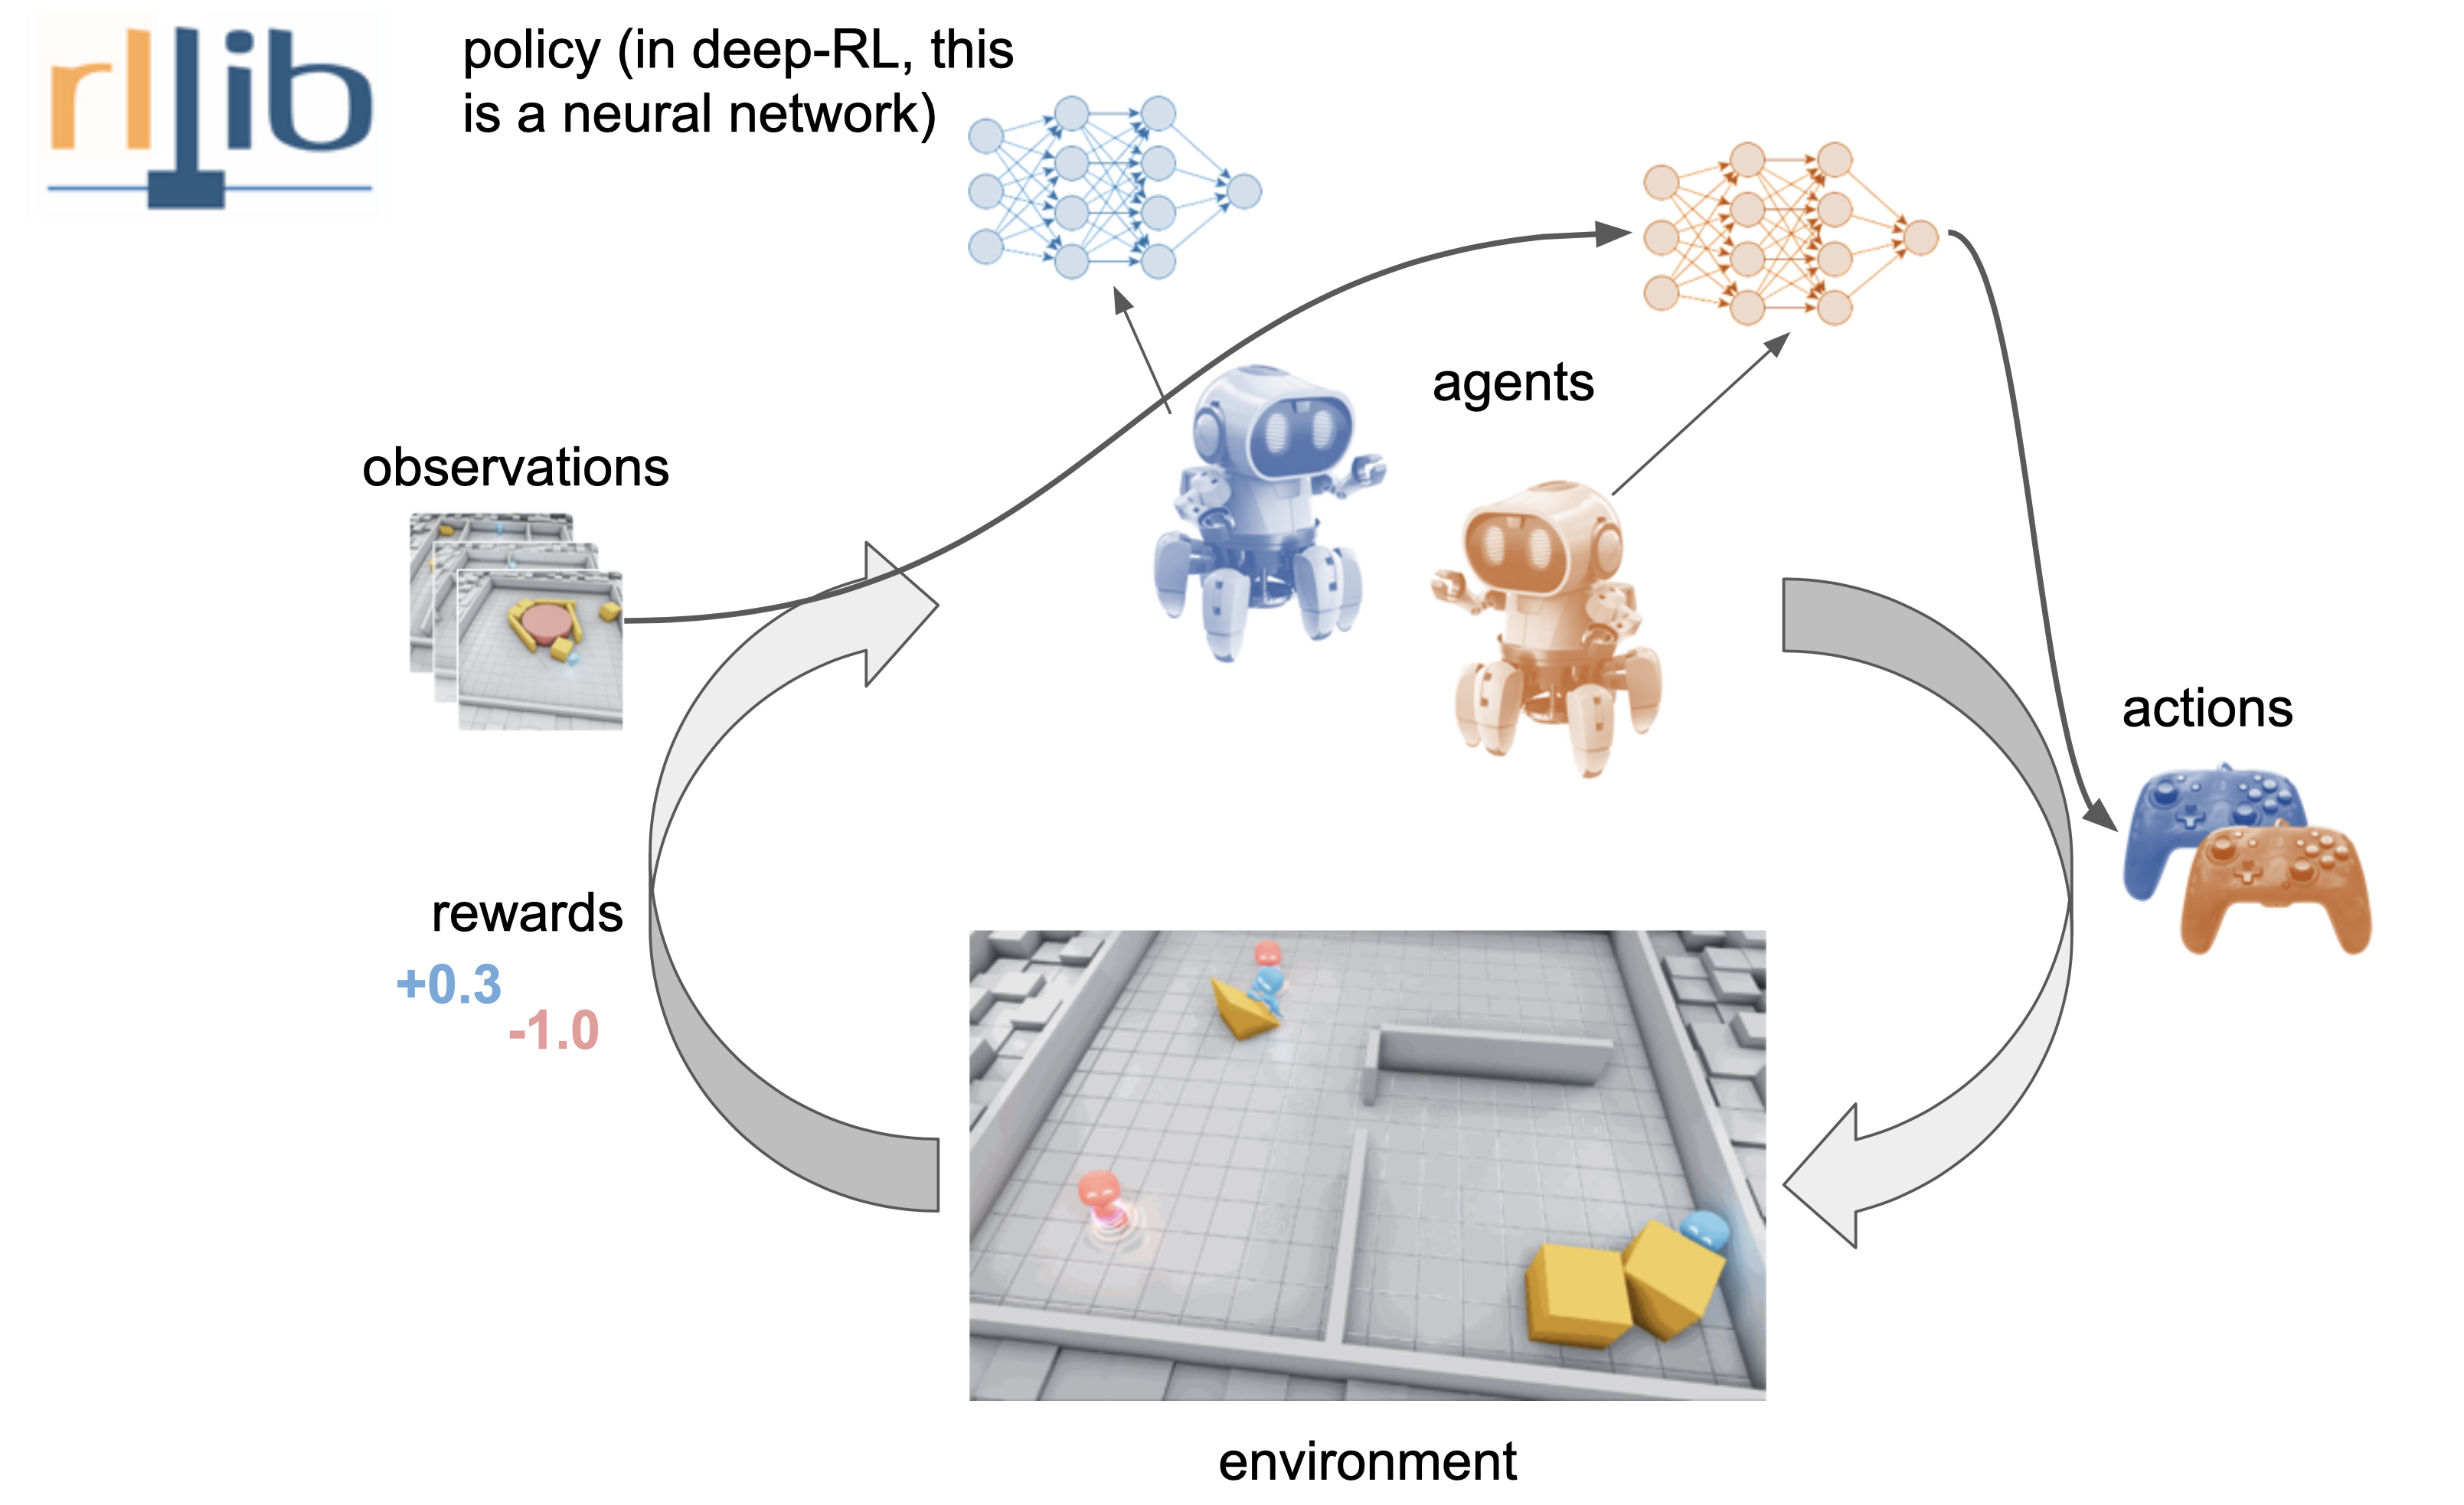

In [2]:
# 2) Coding/defining our "problem" via an RL environment.

import gym
from gym.spaces import Discrete, MultiDiscrete

class MultiAgentArena(gym.Env):
    def __init__(self, config=None):
        config = config or {}
        self.width = config.get("width", 10)
        self.height = config.get("height", 10)

        # 0=up, 1=right, 2=down, 3=left.
        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.width * self.height,
                                                self.width * self.height])
        # End an episode after this many timesteps.
        self.timestep_limit = config.get("ts", 100)
        # Reset env.
        self.reset()

    def reset(self):
        # Row-major coords.
        self.agent1_pos = [0, 0]
        self.agent2_pos = [self.height - 1, self.width - 1]
        # Reset agent1's visited states.
        self.agent1_visited_states = set()
        # How many timesteps have we done in this episode.
        self.timesteps = 0

        return self.get_obs()

    def step(self, action: dict):
        self.timesteps += 1
        # Determine, who is allowed to move first.
        agent1_first = random.random() > 0.5
        # Move first agent (could be agent 1 or 2).
        if agent1_first:
            r1, r2 = self.move(self.agent1_pos, action["agent1"], is_agent1=True)
            add = self.move(self.agent2_pos, action["agent2"], is_agent1=False)
        else:
            r1, r2 = self.move(self.agent2_pos, action["agent2"], is_agent1=False)
            add = self.move(self.agent1_pos, action["agent1"], is_agent1=True)
        r1 += add[0]
        r2 += add[1]

        obs = self.get_obs()

        reward = {"agent1": r1, "agent2": r2}

        done = self.timesteps >= self.timestep_limit
        done = {"agent1": done, "agent2": done, "__all__": done}

        return obs, reward, done, {}

    def get_obs(self):
        ag1_discrete_pos = self.agent1_pos[0] * self.width + \
            (self.agent1_pos[1] % self.width)
        ag2_discrete_pos = self.agent2_pos[0] * self.width + \
            (self.agent2_pos[1] % self.width)
        return {
            "agent1": np.array([ag1_discrete_pos, ag2_discrete_pos]),
            "agent2": np.array([ag2_discrete_pos, ag1_discrete_pos]),
        }

    def move(self, coords, action, is_agent1):
        orig_coords = coords[:]
        # Change the row: 0=up (-1), 2=down (+1)
        coords[0] += -1 if action == 0 else 1 if action == 2 else 0
        # Change the column: 1=right (+1), 3=left (-1)
        coords[1] += 1 if action == 1 else -1 if action == 3 else 0

        # Solve collisions.
        # Make sure, we don't end up on the other agent's position.
        # If yes, don't move (we are blocked).
        if is_agent1 and coords == self.agent2_pos:
            coords[0], coords[1] = orig_coords
            # Agent2 blocked agent1 -> +1 for agent2.
            return 0.0, 1.0
        elif not is_agent1 and coords == self.agent1_pos:
            coords[0], coords[1] = orig_coords
            # Agent1 blocked agent2 -> No reward for either agent.
            return 0.0, 0.0

        # No agent blocking -> check walls.
        if coords[0] < 0:
            coords[0] = 0
        elif coords[0] >= self.height:
            coords[0] = self.height - 1
        if coords[1] < 0:
            coords[1] = 0
        elif coords[1] >= self.width:
            coords[1] = self.width - 1

        # If agent1 -> +1.0 if new tile covered.
        if is_agent1 and not tuple(coords) in self.agent1_visited_states:
            self.agent1_visited_states.add(tuple(coords))
            return 1.0, -0.1
        # No new tile for agent1 -> No reward for either agent.
        return 0.0, 0.0

    # Optionally: Add `render` method returning some img.
    def render(self, mode=None):
        return np.random.randint(0, 256, (20, 20, 3), dtype=np.uint8)


## Exercise No 1

Write an "environment loop" using our `MultiAgentArena` class.

1. Create an env object.
1. `reset` it to get the first observation.
1. `step` through the environment using a provided
   "Trainer.compute_action([obs])" method to compute action dicts (see below).
1. When an episode is done, remember to `reset()` the env before the next call to `step()`.
1. If you feel, this is all too easy for you ;) , try to extract each agent's reward, sum it up over one episode and - at the end of an episode (when done=True) - print out each agent's accumulated reward (also called "return").

**Good luck! :)**


In [3]:
class Trainer:
    """Dummy Trainer class used in Exercise #1.

    Use its compute_action method to get a new action, given some environment
    observation.
    """

    def compute_action(self, obs):
        # Returns a random action.
        return {
            "agent1": np.random.randint(4),
            "agent2": np.random.randint(4)
        }

trainer = Trainer()
# Check, whether it's working.
for _ in range(5):
    print(trainer.compute_action({"agent1": 0, "agent2": 1}))

{'agent1': 0, 'agent2': 0}
{'agent1': 0, 'agent2': 2}
{'agent1': 1, 'agent2': 0}
{'agent1': 0, 'agent2': 2}
{'agent1': 2, 'agent2': 3}


In [4]:
# Solution to Exercise #1:
from environment import MultiAgentArena

from gym.envs.classic_control.rendering import SimpleImageViewer
simple_image_viewer = SimpleImageViewer()

# Solution:
env = MultiAgentArena(config={"width": 10, "height": 10})
obs = env.reset()
# Play through a single episode.
done = {"__all__": False}
return_ag1 = return_ag2 = 0.0
num_episodes = 0
while num_episodes < 10:
    action = trainer.compute_action(obs)
    obs, rewards, done, _ = env.step(action)
    return_ag1 += rewards["agent1"]
    return_ag2 += rewards["agent2"]    
    if done["__all__"]:
        print(f"Episode done. R1={return_ag1} R2={return_ag2}")
        num_episodes += 1
        return_ag1 = return_ag2 = 0.0
        obs = env.reset()
    # Optional:
    img = env.render()
    simple_image_viewer.imshow(img)


Episode done. R1=50.0 R2=-4.999999999999998
Episode done. R1=43.0 R2=-3.3000000000000025
Episode done. R1=41.0 R2=-4.100000000000001
Episode done. R1=40.0 R2=-4.000000000000002
Episode done. R1=13.0 R2=-1.3
Episode done. R1=38.0 R2=-3.800000000000002
Episode done. R1=48.0 R2=-4.799999999999999
Episode done. R1=36.0 R2=-3.600000000000002
Episode done. R1=48.0 R2=-4.799999999999999
Episode done. R1=45.0 R2=-2.5000000000000027


In [7]:
# 4) Plugging in RLlib.

# Import a Trainable (one of RLlib's built-in algorithms):
# We use the PPO algorithm here b/c its very flexible wrt its supported
# action spaces and model types and b/c it learns well almost any problem.
from ray.rllib.agents.ppo import PPOTrainer

# Specify a very simple config, defining our environment and some environment
# options (see environment.py).
config = {
    "env": MultiAgentArena,
    "env_config": {
        "config": {
            "width": 10,
            "height": 10,
        },
    },
    "create_env_on_driver": True,
    "log_level": "ERROR",
}
# Instantiate the Trainer object using above config.
rllib_trainer = PPOTrainer(config=config)


2021-04-28 16:07:22,263	WARNING util.py:53 -- Install gputil for GPU system monitoring.


In [8]:
# That's it, we are ready to train.
# Calling `train` once runs a single "training iteration". One iteration
# for most algos contains a) sampling from the environment(s) + b) using the
# sampled data (observations, actions taken, rewards) to update the policy
# model (neural network), such that it would pick better actions in the future,
# leading to higher rewards.
print(rllib_trainer.train())

{'episode_reward_max': 42.29999999999996, 'episode_reward_min': 19.799999999999997, 'episode_reward_mean': 29.704999999999977, 'episode_len_mean': 100.0, 'episode_media': {}, 'episodes_this_iter': 20, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [36.89999999999997, 34.49999999999998, 33.39999999999998, 35.299999999999976, 25.39999999999999, 32.59999999999998, 32.69999999999998, 24.29999999999999, 31.49999999999998, 23.599999999999994, 42.29999999999996, 25.19999999999999, 31.49999999999998, 37.79999999999997, 19.799999999999997, 27.999999999999986, 29.899999999999984, 24.29999999999999, 25.19999999999999, 19.9], 'episode_lengths': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.12075019764018939, 'mean_inference_ms': 0.47831602029867115, 'mean_action_processing_ms': 0.0481956845873243, 'mean_env_wai

In [10]:
# Run `train()` n times. Try to repeatedly call this to see rewards increase.
# Move on once you see episode rewards > 40.0.
for i in range(5):
    results = rllib_trainer.train()
    print(f"iteration {i}: R={results['episode_reward_mean']}")

iteration 0: R=34.601999999999975
iteration 1: R=35.11699999999997
iteration 2: R=35.42399999999998
iteration 3: R=36.15499999999998
iteration 4: R=36.71399999999997


In [11]:
# Save our trainer.
checkpoint_path = rllib_trainer.save()
print(f"Trainer was saved in '{checkpoint_path}'!")

Trainer was saved in '/Users/sven/ray_results/PPO_MultiAgentArena_2021-04-28_16-07-14h6tjaio3/checkpoint_000011/checkpoint-11'!


In [12]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = PPOTrainer(config=config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer._evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
new_trainer.restore(checkpoint_path)

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer._evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

2021-04-28 16:08:34,521	WARNING util.py:53 -- Install gputil for GPU system monitoring.


AttributeError: 'PPO' object has no attribute 'evaluation_workers'

In [13]:
# 5) Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?
import pprint
from ray.rllib.agents.ppo import DEFAULT_CONFIG as PPO_DEFAULT_CONFIG
print(f"PPO's default config is:")
pprint.pprint(PPO_DEFAULT_CONFIG)
# from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
# print(f"DQN's default config is:")
# pprint.pprint(DQN_DEFAULT_CONFIG)

PPO's default config is:
{'_fake_gpus': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': True,
 'clip_param': 0.3,
 'clip_rewards': None,
 'collect_metrics_timeout': 180,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'eager_tracing': False,
 'entropy_coeff': 0.0,
 'entropy_coeff_schedule': None,
 'env': None,
 'env_config': {},
 'evaluation_config': {},
 'evaluation_interval': None,
 'evaluation_num_episodes': 10,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': False,
 'exploration_config': {'type': 'StochasticSampling'},
 'explore': True,
 'extra_python_environs_for_driver': {},
 'extra_python_environs_for_worker': {},
 'fake_sampler': False,
 'framework': 'tf',
 'gamma': 0.99,
 'grad_clip': None,
 'horizon': None,
 'ignore_worker_failures': False,
 'in_evaluation': False,
 'input': 'sampler',
 'input_e

In [14]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs.

from ray import tune

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
stop = {
    # explain that keys here can be anything present in the above print(trainer.train())
    "training_iteration": 5,
    "episode_reward_mean": 9999.9,
}

# "PPO" is a registered name that points to RLlib's PPOTrainer.
# See `ray/rllib/agents/registry.py`
# Run our simple experiment until one of the stop criteria is met.
tune.run("PPO", config=config, stop=stop)


Trial name,status,loc
PPO_MultiAgentArena_4b397_00000,PENDING,


(pid=22161) 2021-04-28 16:09:11,333	INFO trainer.py:665 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=22161) 2021-04-28 16:09:11,333	INFO trainer.py:690 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=22161) 2021-04-28 16:09:19,180	WARNING util.py:53 -- Install gputil for GPU system monitoring.


Result for PPO_MultiAgentArena_4b397_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-28_16-09-22
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 46.799999999999955
  episode_reward_mean: 32.18999999999997
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: 20516ca190f343ec8bb9f6332f339c89
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 1.365127444267273
          entropy_coeff: 0.0
          kl: 0.021655725315213203
          model: {}
          policy_loss: -0.058211714029312134
          total_loss: 37.334407806396484
          vf_explained_var: 0.49211305379867554
          vf_loss: 37.38829040527344
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_4b397_00000,RUNNING,192.168.0.179:22161,1,2.91523,4000,32.19,46.8,16.2,100


Result for PPO_MultiAgentArena_4b397_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-28_16-09-27
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 46.799999999999955
  episode_reward_mean: 31.97666666666664
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 60
  experiment_id: 20516ca190f343ec8bb9f6332f339c89
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 1.3110098838806152
          entropy_coeff: 0.0
          kl: 0.017605438828468323
          model: {}
          policy_loss: -0.054751619696617126
          total_loss: 24.086181640625
          vf_explained_var: 0.6643529534339905
          vf_loss: 24.13564682006836
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_4b397_00000,RUNNING,192.168.0.179:22161,3,8.66532,12000,31.9767,46.8,16.2,100


Result for PPO_MultiAgentArena_4b397_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-28_16-09-33
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 48.69999999999995
  episode_reward_mean: 34.068999999999974
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 100
  experiment_id: 20516ca190f343ec8bb9f6332f339c89
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 1.2473803758621216
          entropy_coeff: 0.0
          kl: 0.018689293414354324
          model: {}
          policy_loss: -0.057449016720056534
          total_loss: 25.97597312927246
          vf_explained_var: 0.7007890939712524
          vf_loss: 26.02781105041504
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_4b397_00000,TERMINATED,,5,13.9957,20000,34.069,48.7,16.2,100


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_4b397_00000,TERMINATED,,5,13.9957,20000,34.069,48.7,16.2,100


2021-04-28 16:09:34,043	INFO tune.py:549 -- Total run time: 27.65 seconds (26.86 seconds for the tuning loop).


In [15]:
# Updating an algo's default config dict and adding hyperparameter tuning
# options to it.
# Note: Hyperparameter tuning options (e.g. grid_search) will only work,
# if we run these configs via `tune.run`.
config.update(
    {
        # Try 2 different learning rates.
        "lr": tune.grid_search([0.0001, 0.5]),
        # NN model config to tweak the default model
        # that'll be created by RLlib for the policy.
        "model": {
            # e.g. change the dense layer stack.
            "fcnet_hiddens": [256, 256, 256],
            # Alternatively, you can specify a custom model here
            # (we'll cover that later).
            # "custom_model": ...
            # Pass kwargs to your custom model.
            # "custom_model_config": {}
        },
    }
)
# Repeat our experiment using tune's grid-search feature.
results = tune.run(
    "PPO",
    config=config,
    stop=stop,
    checkpoint_at_end=True,  # create a checkpoint when done.
    checkpoint_freq=1,  # create a checkpoint on every iteration.
)
print(results)


Trial name,status,loc,lr
PPO_MultiAgentArena_e1d11_00000,RUNNING,,0.0001
PPO_MultiAgentArena_e1d11_00001,PENDING,,0.5


(pid=22162) 2021-04-28 16:13:24,308	INFO trainer.py:665 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=22162) 2021-04-28 16:13:24,309	INFO trainer.py:690 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=22164) 2021-04-28 16:13:24,308	INFO trainer.py:665 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=22164) 2021-04-28 16:13:24,308	INFO trainer.py:690 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=22162) 2021-04-28 16:13:32,948	WARNING util.py:53 -- Install gputil for GPU system monitoring.
(pid=22164) 2021-04-28 16:13:32,972	WARNING util.py:53 -- Install gputil for GPU system monitoring.


Result for PPO_MultiAgentArena_e1d11_00001:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-28_16-13-37
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 43.29999999999996
  episode_reward_mean: 32.27999999999998
  episode_reward_min: 19.799999999999997
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: c0fd6724ac1442f5bba3d8e5a5814382
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.5
          entropy: 0.08425551652908325
          entropy_coeff: 0.0
          kl: 27.87401580810547
          model: {}
          policy_loss: 0.4978395998477936
          total_loss: 77.18801879882812
          vf_explained_var: 0.08295246958732605
          vf_loss: 71.1153793334961
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_re

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_e1d11_00000,RUNNING,,0.0001,,,,,,,
PPO_MultiAgentArena_e1d11_00001,RUNNING,192.168.0.179:22162,0.5,1,4.76,4000,32.28,43.3,19.8,100


Result for PPO_MultiAgentArena_e1d11_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-04-28_16-13-37
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 38.69999999999997
  episode_reward_mean: 30.714999999999975
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 20
  experiment_id: ab300b97a8024bb7983f83bbc8fb8cbe
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 9.999999747378752e-05
          entropy: 1.3406434059143066
          entropy_coeff: 0.0
          kl: 0.04723317548632622
          model: {}
          policy_loss: -0.0801355242729187
          total_loss: 32.34700012207031
          vf_explained_var: 0.4784521162509918
          vf_loss: 32.417686462402344
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_e1d11_00000,RUNNING,192.168.0.179:22164,0.0001,2,9.42091,8000,31.5775,48.8,16.2,100
PPO_MultiAgentArena_e1d11_00001,RUNNING,192.168.0.179:22162,0.5,3,13.9043,12000,18.2417,60.3,8.1,100


Result for PPO_MultiAgentArena_e1d11_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-04-28_16-13-47
  done: false
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 48.799999999999955
  episode_reward_mean: 31.549999999999976
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 60
  experiment_id: ab300b97a8024bb7983f83bbc8fb8cbe
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 0.44999998807907104
          cur_lr: 9.999999747378752e-05
          entropy: 1.268078088760376
          entropy_coeff: 0.0
          kl: 0.027656450867652893
          model: {}
          policy_loss: -0.06897692382335663
          total_loss: 28.195096969604492
          vf_explained_var: 0.5685566067695618
          vf_loss: 28.251628875732422
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_traine

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_e1d11_00000,RUNNING,192.168.0.179:22164,0.0001,4,18.4467,16000,32.4662,51.7,16.2,100
PPO_MultiAgentArena_e1d11_00001,RUNNING,192.168.0.179:22162,0.5,5,23.0145,20000,14.185,60.3,8.1,100


Result for PPO_MultiAgentArena_e1d11_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-04-28_16-13-56
  done: true
  episode_len_mean: 100.0
  episode_media: {}
  episode_reward_max: 51.69999999999995
  episode_reward_mean: 33.22299999999998
  episode_reward_min: 16.200000000000003
  episodes_this_iter: 20
  episodes_total: 100
  experiment_id: ab300b97a8024bb7983f83bbc8fb8cbe
  hostname: Svens-MacBook-Pro.local
  info:
    learner:
      default_policy:
        learner_stats:
          cur_kl_coeff: 1.0125000476837158
          cur_lr: 9.999999747378752e-05
          entropy: 1.2324594259262085
          entropy_coeff: 0.0
          kl: 0.017946764826774597
          model: {}
          policy_loss: -0.061187662184238434
          total_loss: 30.11931800842285
          vf_explained_var: 0.6146994829177856
          vf_loss: 30.162336349487305
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained:

Trial name,status,loc,lr,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_MultiAgentArena_e1d11_00000,TERMINATED,,0.0001,5,23.0161,20000,33.223,51.7,16.2,100
PPO_MultiAgentArena_e1d11_00001,TERMINATED,,0.5,5,23.0145,20000,14.185,60.3,8.1,100


(pid=22164) 2021-04-28 16:13:56,841	ERROR worker.py:395 -- SystemExit was raised from the worker
(pid=22164) Traceback (most recent call last):
(pid=22164)   File "python/ray/_raylet.pyx", line 496, in ray._raylet.execute_task
(pid=22164)   File "python/ray/_raylet.pyx", line 506, in ray._raylet.execute_task
(pid=22164)   File "python/ray/_raylet.pyx", line 450, in ray._raylet.execute_task.function_executor
(pid=22164)   File "/Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/_private/function_manager.py", line 566, in actor_method_executor
(pid=22164)     return method(__ray_actor, *args, **kwargs)
(pid=22164)   File "/Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/actor.py", line 1005, in __ray_terminate__
(pid=22164)     ray.actor.exit_actor()
(pid=22164)   File "/Users/sven/opt/anaconda3/envs/ray_test2/lib/python3.8/site-packages/ray/actor.py", line 1081, in exit_actor
(pid=22164)     raise exit
(pid=22164) SystemExit: 0
(pid=22164) 


In [16]:
# 6) Going multiagent: Our experiment is ill-configured b/c both
# agents, which should behave differently due to their different
# tasks and reward functions, learn the same policy (the "default_policy",
# which RLlib always provides if you don't configure anything else; Remember
# that RLlib does not know at Trainer setup time, how many and which agents
# the environment will "produce").
# Let's fix this and introduce the "multiagent" API.

# 6.1.) Define an agent->policy mapping function.
# Which agents (defined by the environment) use which policies
# (defined by us)? Mapping is M (agents) -> N (policies), where M >= N.
def policy_mapping_fn(agent):
    return "pol1" if agent == "agent1" else "pol2"

# 6.2.) Define details for our two policies.
#TODO: coding Sven: Make it possible to not need obs/action spaces
#  if they are the default anyways.
observation_space = rllib_trainer.workers.local_worker().env.observation_space
action_space = rllib_trainer.workers.local_worker().env.action_space
# Btw, the above is equivalent to saying:
# >>> rllib_trainer.get_policy("default_policy").obs/action_space
policies = {
    "pol1": (None, observation_space, action_space, {}),
    "pol2": (None, observation_space, action_space, {}),
}
# 6.3) Adding the above to our config.
config.update({
    "multiagent": {
        "policies": policies,
        "policy_mapping_fn": policy_mapping_fn,
    },
})


In [ ]:
# 7) Exercise #2
# Try learning our environment using Ray tune.run and a simple
# hyperparameter grid_search over 2 different learning rates
# (pick your own values) and 2 different `train_batch_size` settings
# (use 2000 and 4000). Also make RLlib use a [64, 64] dense layer
# stack as the NN model.
# Good luck! :)

# Solution to Exercise #2:
tune.run()

In [50]:
# 8) Infinite laptop:
# Start an experiment in the cloud using Anyscale's product, RLlib, and a more complex multi-agent env.


In [48]:
# 9) Custom Neural Network Models.

import tensorflow as tf


class MyModel(tf.keras.Model):
    def __init__(self,
                input_space,
                action_space,
                num_outputs,
                name="",
                *,
                layers = (256, 256)):
        super().__init__(name=name)

        self.dense_layers = []
        for i, layer_size in enumerate(layers):
            self.dense_layers.append(tf.keras.layers.Dense(
                layer_size, activation=tf.nn.relu, name=f"dense_{i}"))

        self.logits = tf.keras.layers.Dense(
            num_outputs,
            activation=tf.keras.activations.linear,
            name="logits")
        self.values = tf.keras.layers.Dense(
            1, activation=None, name="values")

    def call(self, inputs, training=None, mask=None):
        # Standardized input args:
        # - input_dict (RLlib `SampleBatch` object, which is basically a dict with numpy arrays
        # in it)
        out = inputs["obs"]
        for l in self.dense_layers:
            out = l(out)
        logits = self.logits(out)
        values = self.values(out)

        # Standardized output:
        # - "normal" model output tensor (e.g. action logits).
        # - list of internal state outputs (only needed for RNN-/memory enhanced models).
        # - "extra outs", such as model's side branches, e.g. value function outputs.
        return logits, [], {"vf_preds": tf.reshape(values, [-1])}

# Do a quick test.
from gym.spaces import Box
test_model = MyModel(
    input_space=Box(-1.0, 1.0, (2, )),
    action_space=None,
    num_outputs=2,
)
test_model({"obs": np.array([[0.5, 0.5]])})

(<tf.Tensor 'my_model_1/logits/BiasAdd:0' shape=(1, 2) dtype=float64>,
 [],
 {'vf_preds': <tf.Tensor 'my_model_1/Reshape:0' shape=(1,) dtype=float64>})